In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def IDM_v_module(omega, v0, delta, speed, **kwargs):
    return np.power(speed / v0, delta) * omega

def IDM_s_module(omega, s0, T, speed, gap, **kwargs):
    return np.sqrt(omega) * (s0 + speed * T) / gap

def IDM_z_module(d, speed, leaderV, gap, **kwargs):
    return speed * (speed - leaderV) / (2 * np.sqrt(d)) / gap

In [3]:
from trasim_simplified.util.tools import load_from_pickle
from trasim_simplified.core.constant import TrackInfo as TI, Prefix

# 读取轨迹数据
traj_s_full_clb: dict[str, dict[str, pd.DataFrame]] = load_from_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_full_traj_s_IDM.pkl")
traj_s_cut_pos = {v_id: len(df_pair) for v_id, df_pair in traj_s_full_clb["dec"].items()}

traj_s_full: dict[str, pd.DataFrame] = {v_id: pd.concat([df_pair, traj_s_full_clb["acc"][v_id]]) for v_id, df_pair in traj_s_full_clb["dec"].items()}
clb_x_s = [traj_s_full[k][TI.x] for k in traj_s_full.keys()]
clb_v_s = [traj_s_full[k][TI.v] for k in traj_s_full.keys()]
obs_lx_s = [traj_s_full[k][Prefix.leader + TI.x] for k in traj_s_full.keys()]
obs_lv_s = [traj_s_full[k][Prefix.leader + TI.v] for k in traj_s_full.keys()]
leaderL_s = [traj_s_full[k][Prefix.leader + TI.v_Length].unique()[0] for k in traj_s_full.keys()]
id_s = [k for k in traj_s_full.keys()]
assert len(id_s) == len(set(id_s))
print(len(id_s))

690


# 计算各模块的平均加速度以及加速度贡献占比
前期加速度的概念与根据速度波动峰值提取震荡轨迹的思路是一致的，因此没必要使用前期加速度这种表述
前后车两者在减速过程中的平均加速度差值，即两者速度变化量的差异

In [4]:
def cal_module_acc(cf_param_copy, s, v, lv):
    kv = IDM_v_module(**cf_param_copy, speed=v)
    ks = IDM_s_module(**cf_param_copy, speed=v, gap=s)
    ks_2 = np.power(ks, 2)
    kz = IDM_z_module(**cf_param_copy, speed=v, leaderV=lv, gap=s)
    kz_2 = np.power(kz, 2)
    ksz = 2 * ks * kz
    return np.mean(kv), np.mean(ks_2), np.mean(kz_2), np.mean(ksz)
    
def cal_acc_contribution(cf_param: dict, dec_s, dec_v, acc_s, acc_v, dec_a, acc_a, dec_lv, acc_lv):
    cf_param_copy = cf_param.copy()
    
    # 计算平均加速度
    dec_kv, dec_ks_2, dec_kz_2, dec_ksz = cal_module_acc(cf_param_copy, dec_s, dec_v, dec_lv)
    acc_kv, acc_ks_2, acc_kz_2, acc_ksz = cal_module_acc(cf_param_copy, acc_s, acc_v, acc_lv)
    
    # 计算加速度贡献占比
    omega = cf_param_copy["omega"]
    dec_total_a = omega + dec_kv + dec_ks_2 + dec_kz_2 + np.abs(dec_ksz)
    dec_kv_percent = dec_kv / dec_total_a
    dec_ks_2_percent = dec_ks_2 / dec_total_a
    dec_kz_2_percent = dec_kz_2 / dec_total_a
    dec_ksz_percent = np.abs(dec_ksz) / dec_total_a
    
    acc_total_a = omega + acc_kv + acc_ks_2 + acc_kz_2 + np.abs(acc_ksz)
    acc_kv_percent = acc_kv / acc_total_a
    acc_ks_2_percent = acc_ks_2 / acc_total_a
    acc_kz_2_percent = acc_kz_2 / acc_total_a
    acc_ksz_percent = np.abs(acc_ksz) / acc_total_a
    
    # 前后车两者在减速过程中的平均加速度差值，即两者速度变化量的差异
    return {
        "dec_la_mean": np.mean(dec_a), "acc_la_mean": np.mean(acc_a),
        "dec_kv": dec_kv, "dec_ks_2": dec_ks_2, "dec_kz_2": dec_kz_2, "dec_ksz": dec_ksz,
        "acc_kv": acc_kv, "acc_ks_2": acc_ks_2, "acc_kz_2": acc_kz_2, "acc_ksz": acc_ksz,
        "dec_kv_percent": dec_kv_percent, "dec_ks_2_percent": dec_ks_2_percent, "dec_kz_2_percent": dec_kz_2_percent, "dec_ksz_percent": dec_ksz_percent,
        "acc_kv_percent": acc_kv_percent, "acc_ks_2_percent": acc_ks_2_percent, "acc_kz_2_percent": acc_kz_2_percent, "acc_ksz_percent": acc_ksz_percent
    }

In [7]:
# 迟滞强度获取
df_param_merge = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\df_param_hysteresis_merge_IDM.pkl")
df_param_merge

,s0,v0,T,omega,d,delta,Pair_ID,ObjV,dec_vs,acc_vs,total_vs,ori_dec_vs,ori_acc_vs,ori_total_vs,hys_type
0,5.875290,32.483549,1.459826,1.182310,5.000000,9.0,246,11.746341,1.164675,4.112227,5.276903,1.286205,4.549084,5.835289,dec_pos_acc_pos
1,3.736336,15.588722,0.713509,1.340402,3.062311,6.0,249,10.784494,0.492568,4.037313,4.529881,0.919228,3.776405,4.695633,dec_pos_acc_pos
2,7.481041,13.750029,0.822353,2.494765,2.461947,4.0,250,6.412566,0.788053,1.847538,2.635591,1.382829,1.829385,3.212214,dec_pos_acc_pos
3,6.488941,13.216791,1.395703,1.631984,5.000000,8.0,251,18.840322,1.568108,4.381440,5.949548,2.993246,6.148181,9.141427,dec_pos_acc_pos
4,5.923025,14.226246,1.055321,1.611278,1.064573,5.0,255,11.387407,0.479753,2.583461,3.063214,1.319580,2.657784,3.977365,dec_pos_acc_pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,1.059461,15.884867,1.046886,1.260849,3.704961,3.0,18663,9.319589,-0.169557,2.888034,2.718476,0.182431,3.670155,3.852586,dec_neg_acc_pos
258,1.538818,39.765625,0.337604,2.574748,0.373941,9.0,18666,29.852111,-2.802087,-0.097171,-2.899258,-0.792990,1.840059,1.047069,dec_neg_acc_neg
259,2.070358,39.294901,1.563543,2.040773,4.998804,10.0,18667,23.382974,1.283798,1.862485,3.146283,3.297268,2.786405,6.083673,dec_pos_acc_pos
260,7.763055,39.531221,1.164122,0.893350,3.671979,8.0,18668,33.720540,3.354301,10.863290,14.217592,3.349131,14.301526,17.650657,dec_pos_acc_pos


In [8]:
from trasim_simplified.core.constant import CFM
from trasim_simplified.core.kinematics.cfm.CFModel_IDM import cf_IDM_acc_module, cf_IDM_equilibrium_module

dt = 0.1
cf_name = CFM.IDM
cf_func = cf_IDM_acc_module
cf_e = cf_IDM_equilibrium_module

In [8]:
from itertools import product
from trasim_simplified.util.calibrate.follow_sim import simulation
import joblib

pos = np.arange(0.1, 5.2, 0.5)
print(pos)
k_list = list(product(pos, pos, pos))
# for clb_v, clb_x, obs_lx, obs_lv, leaderL, v_id in zip(clb_v_s, clb_x_s, obs_lx_s, obs_lv_s, leaderL_s, id_s):
#     single_traj_run(cf_func, cf_e, cf_params[v_id], clb_v, clb_x, obs_lx, obs_lv, leaderL, v_id, k_list)
#     print("OK")

def run(param_df):
    clb_v_s_ = [traj_s_full[k][TI.v] for k in param_df[TI.Pair_ID]]
    clb_x_s_ = [traj_s_full[k][TI.x] for k in param_df[TI.Pair_ID]]
    obs_lx_s_ = [traj_s_full[k][Prefix.leader + TI.x] for k in param_df[TI.Pair_ID]]
    obs_lv_s_ = [traj_s_full[k][Prefix.leader + TI.v] for k in param_df[TI.Pair_ID]]
    leaderL_s_ = [traj_s_full[k][Prefix.leader + TI.v_Length].unique()[0] for k in param_df[TI.Pair_ID]]
    cf_params = {pair_id: {name: param_df[param_df[TI.Pair_ID] == pair_id][name].iloc[0] for name in get_cf_default_param(cf_name).keys()} for pair_id in param_df[TI.Pair_ID]}
    return joblib.Parallel(n_jobs=-1)(
        joblib.delayed(single_traj_run)(cf_func, cf_e, cf_params[pair_id], clb_v, clb_x, obs_lx, obs_lv, leaderL, pair_id, k_list) for clb_v, clb_x, obs_lx, obs_lv, leaderL, pair_id in zip(clb_v_s_, clb_x_s_, obs_lx_s_, obs_lv_s_, leaderL_s_, param_df[TI.Pair_ID]))

results = [run(param_df) for param_df in [dec_neg_acc_neg, dec_neg_acc_pos, dec_pos_acc_neg, dec_pos_acc_pos]]
results[0][0]

[0.1 0.6 1.1 1.6 2.1 2.6 3.1 3.6 4.1 4.6 5.1]


([[0.1,
   0.1,
   0.1,
   3.9183160797108263,
   18.07917535227392,
   21.99749143198475,
   0.8911225449294058,
   18.084833083038895,
   7.715828757756216,
   0.73843178456553,
   0.8896067955789456,
   5.665249545998412,
   6.477598199395291,
   0.9791422770921552,
   12.277148580944765,
   11.29800630385261,
   153,
   127],
  [0.1,
   0.1,
   0.6,
   3.6318980280384836,
   17.244561806373994,
   20.876459834412476,
   0.7609853550652717,
   16.941920313366886,
   7.233875269387961,
   0.7192277105207174,
   0.8733479342037282,
   5.685431487621409,
   6.56707110200671,
   1.2729646099777878,
   12.277148580944765,
   11.004183970966977,
   153,
   126],
  [0.1,
   0.1,
   1.1,
   3.3991263660719206,
   16.462190386710688,
   19.86131675278261,
   0.7186718674349133,
   15.933591021177127,
   6.742019390903815,
   0.6984077696384069,
   0.8604383721945174,
   5.748940026273148,
   6.644516327954241,
   1.5216689285132976,
   12.277148580944765,
   10.755479652431466,
   154,
   12

In [19]:
result_df_full = pd.DataFrame()

names = ["dec_neg_acc_neg", "dec_neg_acc_pos", "dec_pos_acc_neg", "dec_pos_acc_pos"]

for i, df_param in enumerate([dec_neg_acc_neg, dec_neg_acc_pos, dec_pos_acc_neg, dec_pos_acc_pos]):
    result = results[i]
    pair_id = df_param[TI.Pair_ID]
    
    
    column_names = result[0][1]
    result_df = pd.DataFrame(columns=column_names)
    
    for j, pair_id in enumerate(pair_id):
        temp_df = pd.DataFrame(np.array(result[j][0]), columns=column_names)
        temp_df[TI.Pair_ID] = pair_id
        result_df = pd.concat([result_df, temp_df], axis=0)
    
    result_df["hys_type"] = names[i]
    
    result_df_full = pd.concat([result_df_full, result_df], axis=0)

result_df_full

C:\Users\Enze Zhao\AppData\Local\Temp\ipykernel_18368\3282970536.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, temp_df], axis=0)
C:\Users\Enze Zhao\AppData\Local\Temp\ipykernel_18368\3282970536.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, temp_df], axis=0)
C:\Users\Enze Zhao\AppData\Local\Temp\ipykernel_18368\3282970536.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is d

,k_speed,k_space,k_zero,dec_vs,acc_vs,total_vs,dec_ts,acc_ts,total_ts,dec_avg_acc,acc_avg_acc,dec_avg_speed,acc_avg_speed,min_speed,max_speed,dv,dec_step,acc_step,Pair_ID,hys_type
0,0.1,0.1,0.1,3.918316,18.079175,21.997491,0.891123,18.084833,7.715829,0.738432,0.889607,5.665250,6.477598,0.979142,12.277149,11.298006,153.0,127.0,1.0,dec_neg_acc_neg
1,0.1,0.1,0.6,3.631898,17.244562,20.876460,0.760985,16.941920,7.233875,0.719228,0.873348,5.685431,6.567071,1.272965,12.277149,11.004184,153.0,126.0,1.0,dec_neg_acc_neg
2,0.1,0.1,1.1,3.399126,16.462190,19.861317,0.718672,15.933591,6.742019,0.698408,0.860438,5.748940,6.644516,1.521669,12.277149,10.755480,154.0,125.0,1.0,dec_neg_acc_neg
3,0.1,0.1,1.6,3.261768,15.755146,19.016914,0.695253,15.155457,6.374848,0.688993,0.855684,5.764105,6.695810,1.666663,12.277149,10.610486,154.0,124.0,1.0,dec_neg_acc_neg
4,0.1,0.1,2.1,2.937942,15.119622,18.057564,0.631602,14.567275,6.093081,0.680766,0.857876,5.822319,6.723713,1.725268,12.277149,10.551880,155.0,123.0,1.0,dec_neg_acc_neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,5.1,5.1,3.1,-6.621346,-4.573087,-11.194432,0.213192,-2.704295,-1.325180,0.307372,0.381210,4.753050,4.389191,1.265481,8.089135,6.823654,222.0,179.0,642.0,dec_pos_acc_pos
1327,5.1,5.1,3.6,-6.879471,-4.746962,-11.626433,0.345101,-3.042365,-1.545383,0.303954,0.379088,4.739051,4.412901,1.289226,8.036994,6.747768,222.0,178.0,642.0,dec_pos_acc_pos
1328,5.1,5.1,4.1,-6.968105,-5.166581,-12.134686,0.512850,-3.302312,-1.746381,0.301283,0.380027,4.725357,4.413924,1.309069,7.997548,6.688479,222.0,176.0,642.0,dec_pos_acc_pos
1329,5.1,5.1,4.6,-5.456423,-5.555867,-11.012290,0.717514,-3.562875,-1.971767,0.328619,0.416877,4.711804,4.433088,0.672752,7.968102,7.295350,222.0,175.0,642.0,dec_pos_acc_pos


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x00000241ECD96E60> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x000002419AB8AD40> (for post_execute):


KeyboardInterrupt: 

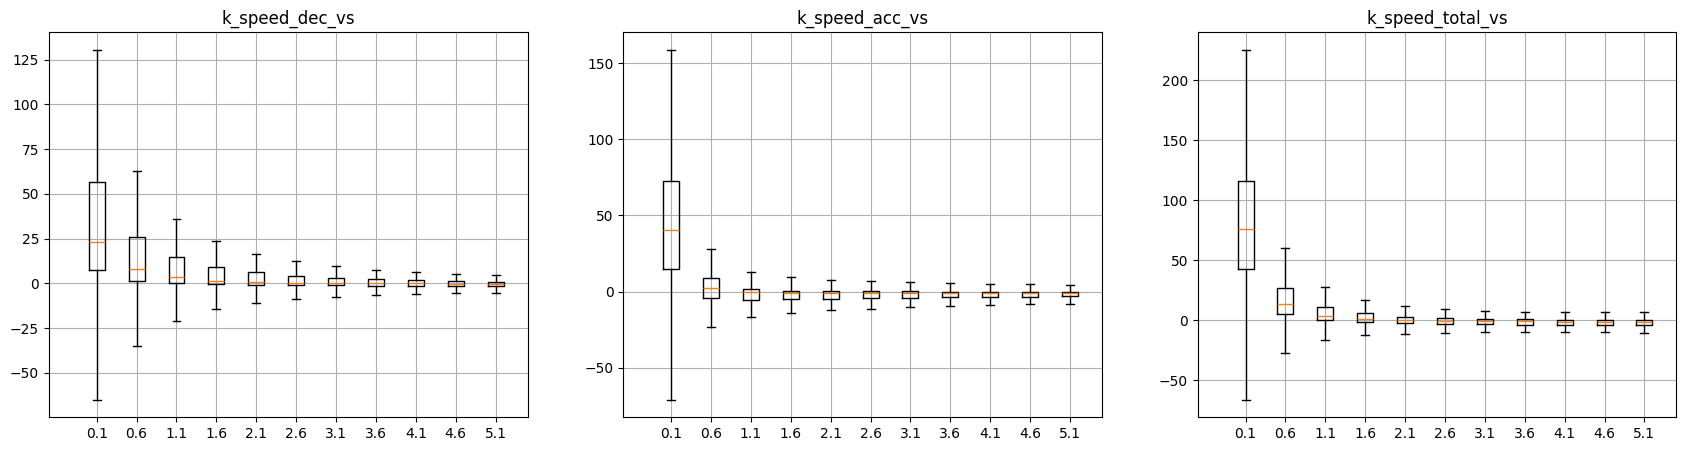

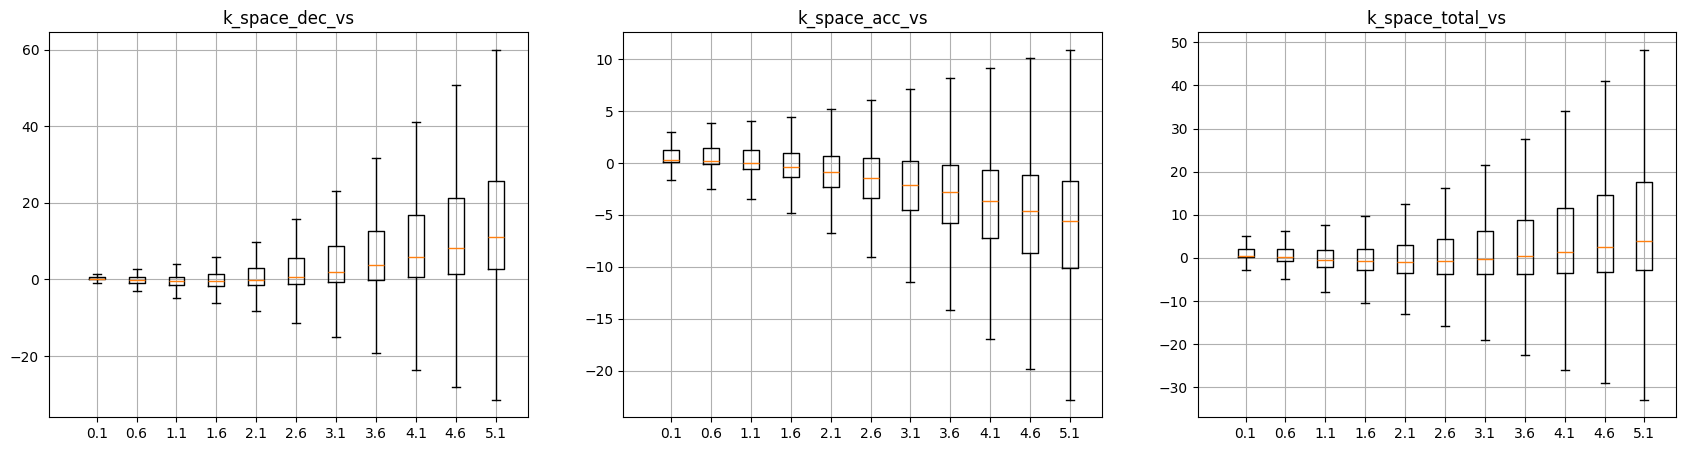

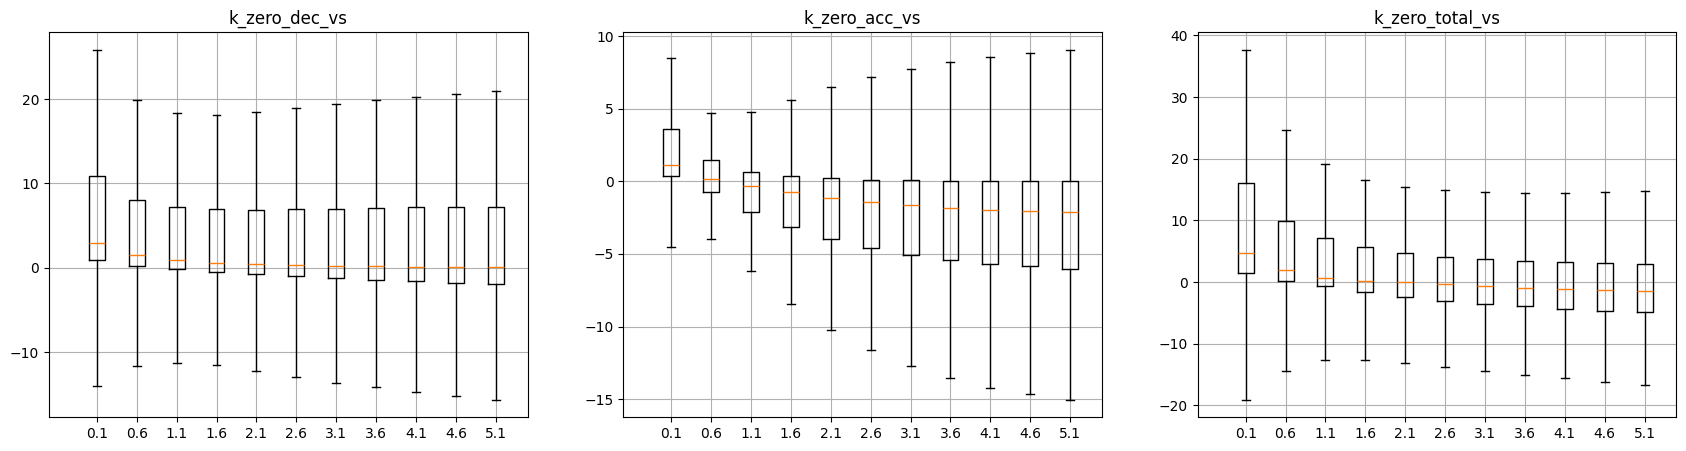

In [16]:
for hys_type in ["dec_neg_acc_neg", "dec_neg_acc_pos", "dec_pos_acc_neg", "dec_pos_acc_pos"]:
    result_df = result_df_full[result_df_full["hys_type"] == hys_type]
    result_df = result_df[(np.isfinite(result_df["dec_vs"]) & np.isfinite(result_df["acc_vs"]))]
    for k in ["k_speed", "k_space", "k_zero"]:
        temp: pd.DataFrame = result_df.groupby([k]).mean().reset_index()
        fig, axes = plt.subplots(1, 3, figsize=(21, 5))
        axes: np.ndarray[plt.Axes] = axes
        # ax.plot(temp[k], temp["dec_vs"], label="dec_vs")
        # ax.plot(temp[k], temp["acc_vs"], label="acc_vs")
        # ax.plot(temp[k], temp["total_vs"], label="total_vs")
    
        for ax_, index in zip(axes, ["dec_vs", "acc_vs", "total_vs"]):
            ax_: plt.Axes = ax_
            ax_.boxplot([result_df[result_df[k] == i][index] for i in temp[k]], positions=temp[k], showfliers=False, widths=0.2)
            # ax_.set_xscale("log")
            # ax_.set_xticks(temp[k])
            ax_.set_xticklabels([f"{t:.1f}" for t in temp[k]])
            ax_.set_xlim([-0.5, 5.5])
            ax_.grid()
            ax_.set_title(k + "_" + index)
    #     fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result_{}.png".format(k))
    # result_df.to_csv(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result_infinite.csv", index=False)

# 探究平均加速度的大小与迟滞强度的关系